### OpenCV DNN 패키지를 이용하여 SSD 기반 Object Detection 수행
* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행. 

# 아래는 OpenCV 실습 예제이므로 GPU가 필요하지 않으며 코랩 커널을 GPU로 바꿀 필요가 없습니다. 


OpenCV는 Colab에서 이미 설치 되어 있으니 추가설치는 필요 없습니다.

강의 실습코드와 데이터는 https://github.com/chulminkw/DLCV.git 에서 다운로드 할 수 있습니다. 

In [19]:
!git clone https://github.com/chulminkw/DLCV.git

Cloning into 'DLCV'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 357 (delta 94), reused 196 (delta 92), pack-reused 159
Receiving objects: 100% (357/357), 274.48 MiB | 38.62 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [ ]:
# DLCV 디렉토리가 Download되고 DLCV 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
!ls -lia 
!ls -lia DLCV

total 20
3670041 drwxr-xr-x 1 root root 4096 Jun 16 13:03 .
5768455 drwxr-xr-x 1 root root 4096 Jun 16 13:03 ..
5898256 drwxr-xr-x 4 root root 4096 Jun  1 13:40 .config
5768429 drwxr-xr-x 8 root root 4096 Jun 16 13:03 DLCV
3670042 drwxr-xr-x 1 root root 4096 Jun  1 13:40 sample_data
total 22108
5768429 drwxr-xr-x 8 root root     4096 Jun 16 13:03  .
3670041 drwxr-xr-x 1 root root     4096 Jun 16 13:03  ..
5768628 drwxr-xr-x 2 root root     4096 Jun 16 13:03  colab_tf115_modify_files
5768631 drwxr-xr-x 6 root root     4096 Jun 16 13:03  data
5768513 drwxr-xr-x 8 root root     4096 Jun 16 13:03  Detection
5768498 -rw-r--r-- 1 root root  6567662 Jun 16 13:03  DLCV_Colab_SrcCode_20200905.zip
5768612 -rw-r--r-- 1 root root   141521 Jun 16 13:03  GCP_GPU_Driver_Install.pptx
5768430 drwxr-xr-x 8 root root     4096 Jun 16 13:03  .git
5768677 -rw-r--r-- 1 root root 11210614 Jun 16 13:03  incredibles.zip
5768678 -rw-r--r-- 1 root root  2063693 Jun 16 13:03  labelimg.pptx
5768679 drwxr-xr-x 2 roo

#### 입력 이미지로 사용될 이미지 보기

image shape: (633, 806, 3)


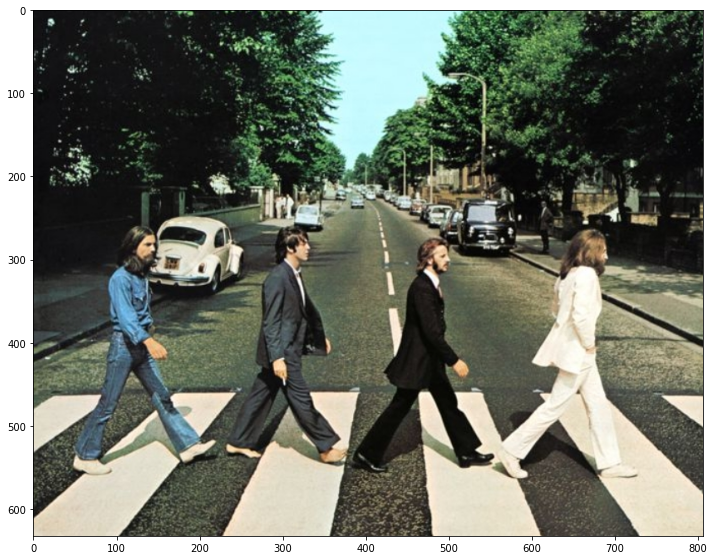

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

# 코랩 버전은 상대 경로를 사용하지 않습니다. /content 디렉토리를 기준으로 절대 경로를 이용합니다. 
# default_dir 은 /content/DLCV로 지정하고 os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_dir = '/content/DLCV'

img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt 에서 다운로드 
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 


In [ ]:
#코랩 버전은 OS 터미널이 아닌 코랩 Cell 에서 os command를 수행해야 합니다. 
#아래 command는 코랩에서 OS 명령어를 통해 ssd/pretrained 디렉토리를 만듭니다. 

!rm -rf /content/DLCV/Detection/ssd//pretrained
!mkdir /content/DLCV/Detection/ssd/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/DLCV/Detection/ssd
!ls

/content/DLCV/Detection/ssd
OpenCV_SSD_이미지와_영상_Detection.ipynb
pretrained
SSD_Face_Detection.ipynb
Tensorflow_SSD_이미지와_영상_Detection.ipynb


In [ ]:
### coco 데이터 세트로 pretrained 된 ssd 파일과 config용 graph pbtxt 다운로드 
%cd /content/DLCV/Detection/ssd/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt


# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf ssd_inception*.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/DLCV/Detection/ssd/pretrained/ssd_inception*.pbtxt /content/DLCV/Detection/ssd/pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/faster_rcnn_resnet50_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/ssd_inception_v2_coco_2017_11_17"
!ls /content/DLCV/Detection/ssd/pretrained/ssd_inception_v2_coco_2017_11_17

/content/DLCV/Detection/ssd/pretrained
##### downloading pretrained weight file and config pbtxt file
--2021-06-16 13:04:10--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.33.208, 2607:f8b0:4004:837::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.33.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘ssd_inception_v2_coco_2017_11_17.tar.gz’

ssd_inception_v2_co 100%[===================>] 265.24M   161MB/s    in 1.6s    

2021-06-16 13:04:12 (161 MB/s) - ‘ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2021-06-16 13:04:12--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199

In [ ]:
#코랩 버전은 default_ssd_dir 절대 경로를 이용합니다. os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_ssd_dir='/content/DLCV/Detection/ssd'
cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'),
                                       os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt'))

#### coco 데이터 세트의 클래스id별 클래스명 지정. 

In [ ]:
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

In [ ]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화 

(1, 1, 100, 7)
person: 0.9696 1
person: 0.9660 1
person: 0.8916 1
person: 0.6298 1
car: 0.8609 3
car: 0.7223 3
car: 0.7184 3
car: 0.7095 3
car: 0.5949 3
car: 0.5511 3


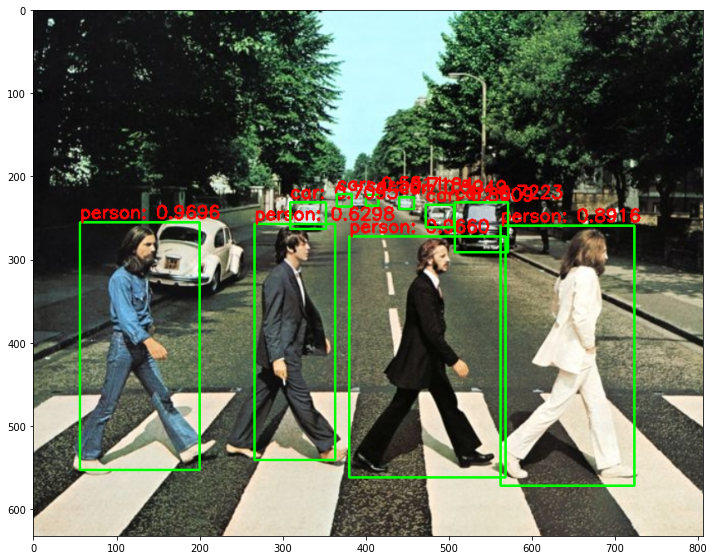

In [ ]:
# 원본 이미지 (633, 806)를 네트웍에 입력시에는 (300, 300)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열을 사이즈 (300, 300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,  size=(300, 300), swapRB=True, crop=False))
# Object Detection 수행하여 결과를 cv_out으로 반환 
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.4 이상만 추출
    if score > 0.4:
        # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
        
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
        print(caption, class_id)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 단일 이미지의 object detection을 함수로 생성

In [ ]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.4 이상만 추출
        if score > score_threshold:
            # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

Detection 수행시간: 0.38 초


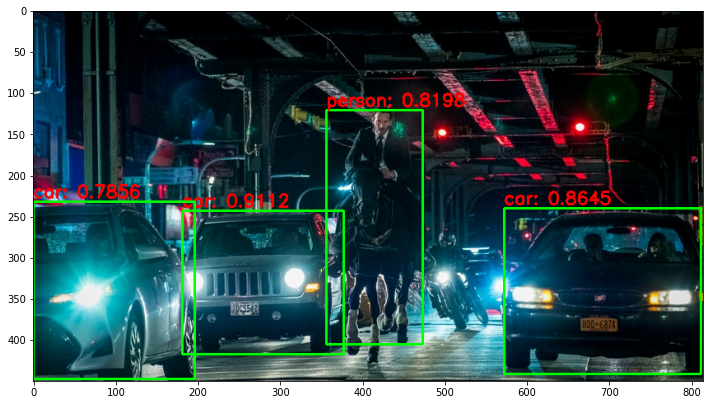

In [ ]:
# image 로드 
#코랩 버전은 default_dir, default_rcnn_dir 절대 경로를 이용합니다. os.path.join()으로 상세 파일/디렉토리를 지정합니다. 

img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))

#coco dataset 클래스명 매핑

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'),
                                       os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt'))
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net, img, score_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

### Video Object Detection 수행

#### 원본 영상 보기

In [ ]:
# 코랩 버전은 아래 코드를 이용합니다.
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/DLCV/data/video/John_Wick_small.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

#### VideoCapture와 VideoWriter 설정하기
* VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
* VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정. 
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정 

##### 총 Frame 별로 iteration 하면서 Object Detection 수행. 개별 frame별로 단일 이미지 Object Detection과 유사 

#### video detection 전용 함수 생성. 

In [ ]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, )

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        returned_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=True, is_print=True)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [ ]:
#코랩 버전은 default_dir 절대 경로를 이용합니다.
default_dir = '/content/DLCV'

do_detected_video(cv_net, os.path.join(default_dir, 'data/video/John_Wick_small.mp4'), os.path.join(default_dir, 'data/output/John_Wick_small_ssd01.avi'), 0.4, True)

총 Frame 갯수: 58
Detection 수행시간: 0.37 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.37 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.37 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.3

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다.

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/John_Wick_small_ssd01.avi '/content/gdrive/My Drive/John_Wick_small_ssd01.avi'

### SSD+Mobilenet으로 Object Detection 수행. 
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음. 
* weight파일은 http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz 에서 다운로드

In [ ]:
### 코랩 버전은 아래를 이용하여 os command 를 수행합니다. 

# coco 데이터 세트로 pretrained 된 ssd 파일과 config용 graph pbtxt 다운로드 
%cd /content/DLCV/Detection/ssd/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_mobilenet_v2_coco_2018_03_29.pbtxt


# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/DLCV/Detection/ssd/pretrained/ssd_mobilenet_v2_coco_2018_03_29.pbtxt /content/DLCV/Detection/ssd/pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/faster_rcnn_resnet50_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/ssd_mobilenet_v2_coco_2018_03_29"
!ls /content/DLCV/Detection/ssd/pretrained/ssd_mobilenet_v2_coco_2018_03_29

/content/DLCV/Detection/ssd/pretrained
##### downloading pretrained weight file and config pbtxt file
--2021-04-07 17:36:57--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.187.128, 2404:6800:4008:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.187.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   113MB/s    in 1.6s    

2021-04-07 17:36:59 (113 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’ saved [187925923/187925923]

--2021-04-07 17:36:59--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_mobilenet_v2_coco_2018_03_29.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.1

In [ ]:
default_ssd_dir='/content/DLCV/Detection/ssd'
cv_net_mobile = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb'),
                                              os.path.join(default_ssd_dir, 'pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt'))

#### 영상 Detection

In [ ]:
default_dir = '/content/DLCV'

do_detected_video(cv_net_mobile, os.path.join(default_dir,'data/video/John_Wick_small.mp4'),
                  os.path.join(default_dir, 'data/output/John_Wick_small_ssd_mobile01.avi'), 0.2, True)

총 Frame 갯수: 58
Detection 수행시간: 0.27 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.24 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.25 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.24 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.23 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.22 초
Detection 수행시간: 0.2

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다.
!cp /content/DLCV/data/output/John_Wick_small_ssd_mobile01.avi '/content/gdrive/My Drive/John_Wick_small_ssd_mobile01.avi' 

In [ ]:
# 코랩 버전은 상대 경로를 사용하지 않습니다. /content 디렉토리를 기준으로 절대 경로를 이용합니다. 
# default_dir 은 /content/DLCV로 지정하고 os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
# image 로드 
default_dir = '/content/DLCV'
default_ssd_dir = '/content/DLCV/Detection/ssd'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))

#coco dataset 클래스명 매핑

cv_net_mobile = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb'), 
                                              os.path.join(default_ssd_dir, 'pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt'))

# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_mobile, img, score_threshold=0.4, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)